#### Purpose: We want daily snapshot images of a flood, so that e.g. a flood lasting for 100 days, gets 100 unique extent images, one for each day

Creates and saves the dataframe "flooddays_df"

**ASSUMPTIONS:**

* Assumption 1: the "duration" value in the Global Flood Database tiff images are all calculated from a common "day 1" corresponding to the start of the flood.

* Assumption 2: the flood extent layer in the tiff images from Global Flood Database already exclude permanent water co-ordinates, i.e. pixels are labelled as flood according to the basic idea that **flood pixel = pixel changed from not water to water**

* Assumption 3: duration data follow a simplified flood model whereby water levels rise to the maximum on the first day and then durations "per pixel" drop over time as the water subsides.

#### **HUOM!** we replace the reported duration (apparent in "flood end" date of the tif filename), with the observed end date according to duration values.

Similarly we add a "observed total duration" value for the flood, which is consistent with the number of snapshot days stored.

**BUT** we keep the reported duration (derived from the filename) because this is needed to join on data from the Global Flood Database website (necessary because the DFO id is not taken from the web site, and start date alone can not be used as a unique joining key for a flood - there can be >1 flood starting on the same day)

Finally note that we derive the exteny in km2 from the number of pixels counted as flood on a particular day. Each pixel is 250mx250m in the Global Flood Database tiff images according to PDF documentation bundled in with image download. This amounts to a sixteenth of aS km2

In [1]:
import pickle
import cv2
import skimage
from matplotlib import pyplot as plt
import numpy as np
from datetime import timedelta
import pandas as pd


gfd_root = "STEP 1 - Data Acquisition/Global Flood Database/"
gfd_tif_dir = "STEP 1 - Data Acquisition/Global Flood Database/TIF/unzipped/"
sentinel_root = "STEP 1  - Data Acquisition/Sentinel from Copernicus/"

Get the ID and start/end dates of the Indian floods according to the Global Flood Database

Number of flood events per year from Global Flood Database


<Axes: >

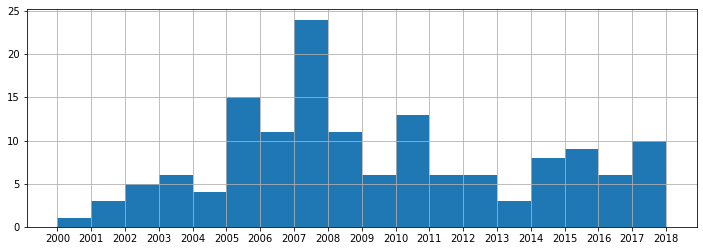

In [2]:
with open(gfd_root+'meta_tif_df.pkl', 'rb') as f:
    floods_df = pickle.load(f) 
f.close()
print("Number of flood events per year from Global Flood Database")
floods_df.flood_year.hist(bins=18,figsize=(12,4))

Cut down data to years from 2010 onwards and inspect the flood detalis

In [3]:
#cut down data to 2 years 2017-2018, i.e. the most recent years available without exceeding memory limitations after expanding to daily resolution
floods_df = floods_df[floods_df.flood_year>='2017']
print(floods_df.shape[0],"flood events chosen for analysis")
floods_df.head()

10 flood events chosen for analysis


,DFO_id,tif_filename,flood_year,flood_start,flood_end
137,DFO_4459,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,2017-04-18
138,DFO_4483,DFO_4483_From_20170602_to_20170703.tif,2017,2017-06-02,2017-07-03
139,DFO_4499,DFO_4499_From_20170727_to_20170810.tif,2017,2017-07-27,2017-08-10
140,DFO_4507,DFO_4507_From_20170810_to_20170826.tif,2017,2017-08-10,2017-08-26
141,DFO_4508,DFO_4508_From_20170810_to_20170826.tif,2017,2017-08-10,2017-08-26


* **Observation:** Duration values in the image data can be longer than the flood duration implied in the filename (start / end dates)
* **Decision:** use the max duration infetted by the image to control the image splitting operation, not the dates in the filenmaes

Create the flood-day-level dataframe as the backbone of all subsequent analysis

In [4]:

DFO_id = []
DFO_day_id = []
flood_day = []
tif_filename= []
flood_year= []
flood_start= []
reported_duration = []
observed_duration= []
snapshot_date = []
snapshot_extent_img=[]
snapshot_extent_km2=[]

for index, row in floods_df.iterrows():
    img_filename = gfd_tif_dir+row['tif_filename']
    img = skimage.io.imread(img_filename,plugin='tifffile')
    duration_img = img[:,:,1]
    duration_data = duration_img.ravel()
    duration_data = duration_data[~np.isnan(duration_data)]
    n_days = int(max(duration_data))
    
    reported_ndays = (row['flood_end'] - row['flood_start']).days

    for day in range(n_days):
        im_t = duration_img.copy()
        _,im_t = cv2.threshold(im_t,day,1,cv2.THRESH_BINARY)

        data = im_t.ravel()
        data = data[~np.isnan(data)]
        pixel_area = int(sum(data))

        # store all day-level data in their own row
        DFO_id.append(row['DFO_id'])
        flood_day.append(day)
        DFO_day_id.append(row['DFO_id']+"_"+str(day))
        tif_filename.append(row['tif_filename'])
        flood_year.append(row['flood_year'])
        flood_start.append(row['flood_start'])
        observed_duration.append(n_days)
        reported_duration.append(reported_ndays)
        snapshot_date.append(row['flood_start'] + timedelta(days=day))
        snapshot_extent_img.append(im_t)
        snapshot_extent_km2.append(pixel_area*0.0625) # each pixel is 250mx250m = one sixteenth of a km2


flooddays_df = pd.DataFrame({'DFO_id' :DFO_id,
                'DFO_day_id' :DFO_day_id,
                'flood_day' :flood_day,
                'tif_filename':tif_filename,
                'flood_year':flood_year,
                'flood_start':flood_start,
                'reported_duration':reported_duration,
                'observed_total_duration':observed_duration,
                'snapshot_date' :snapshot_date,
                'snapshot_extent_img':snapshot_extent_img,
                'snapshot_extent_km2':snapshot_extent_km2}).set_index('DFO_day_id')



In [5]:
print(flooddays_df.shape[0],"flood daily snapshots chosen for analysis")
flooddays_df.head(10)

155 flood daily snapshots chosen for analysis


,DFO_id,flood_day,tif_filename,flood_year,flood_start,reported_duration,observed_total_duration,snapshot_date,snapshot_extent_img,snapshot_extent_km2
DFO_day_id,,,,,,,,,,
DFO_4459_0,DFO_4459,0,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-03-30,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",8721.8125
DFO_4459_1,DFO_4459,1,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-03-31,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",8166.0625
DFO_4459_2,DFO_4459,2,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-04-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7618.3750
DFO_4459_3,DFO_4459,3,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-04-02,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7086.9375
DFO_4459_4,DFO_4459,4,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-04-03,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6669.7500
DFO_4459_5,DFO_4459,5,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-04-04,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6179.8750
DFO_4459_6,DFO_4459,6,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-04-05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5581.3125
DFO_4459_7,DFO_4459,7,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-04-06,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4939.3125
DFO_4459_8,DFO_4459,8,DFO_4459_From_20170330_to_20170418.tif,2017,2017-03-30,19,22,2017-04-07,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4306.6875


In [6]:
with open('flooddays_df.pkl', 'wb') as f:  
    pickle.dump(flooddays_df, f) 

f.close()

Sanity check - do we get a binary image for each specific day? (inspect an arbitrary dataframe row)

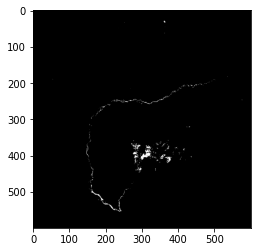

In [7]:
test_image = flooddays_df.iloc[10].snapshot_extent_img
plt.imshow(255*cv2.resize(test_image, (600,600)),'gray')
plt.show()